<a href="https://colab.research.google.com/github/hashimmg/jax_ib/blob/main/taylor_dispersion_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Taylor Dispersion Demo

By Kaylie Hausknecht

## Import Packages

Note that as of January 2024, "!pip install jax_cfd" does not import the most recent version of jax_cfd, so we clone the github repository here.

In [1]:
%%capture
!git clone https://github.com/hashimmg/jax_ib.git
!git clone https://github.com/google/jax-cfd.git
!pip install jax_md
!pip install jax
%cd /content/jax-cfd/
!pip install -e .
%cd /content/jax_ib/

In [43]:
import sys
sys.path.append('/content/jax-cfd/')
import jax_cfd.base as cfd
import jax_ib
import jax
import jax.numpy as jnp
import jax_ib.MD as MD
from jax import random, jit
from jax_md import space, quantity, simulate, smap
from jax.random import uniform as random_uniform
import numpy as np
from matplotlib import pyplot as plt

## CFD Simulation: Channel Flow

This JAX-CFD code to simulate flow through a channel is adapted directly from the JAX-CFD channel flow demo, linked here: https://github.com/google/jax-cfd/blob/main/notebooks/channel_flow_demo.ipynb.

In [41]:
f32 = jnp.float32
f64 = jnp.float64

size = (1024, 256)
domain = ((0, 4), (0, 1))
density = 1.
viscosity = 1e-3  # kinematic visocity
pressure_gradient = 2e-3  # uniform dP/dx

# Define the physical dimensions of the simulation.
grid = cfd.grids.Grid(size, domain=domain)

# Specify periodic BC on x-boundaries, and no-slip walls on the y-boundaries.
velocity_bc = (cfd.boundaries.channel_flow_boundary_conditions(ndim=2),
               cfd.boundaries.channel_flow_boundary_conditions(ndim=2))

# Specify zero velocity initial conditions
vx_fn = lambda x, y: jnp.zeros_like(x + y)
vy_fn = lambda x, y: jnp.zeros_like(x + y)

v0 = cfd.initial_conditions.initial_velocity_field(
    velocity_fns=(vx_fn, vy_fn),
    grid=grid,
    velocity_bc=velocity_bc,
    pressure_solve=cfd.pressure.solve_fast_diag_channel_flow,
    iterations=5)

# Confirm that the divergence of v0 is zero
div = cfd.finite_differences.divergence(v0)
np.testing.assert_allclose(div.data, 0)

# Specify a fixed time step based on the convection and diffusion scales
max_velocity = 1  # value selected from known equilibirum profile
cfl_safety_factor = 0.5

dt = cfd.equations.stable_time_step(
    max_velocity, cfl_safety_factor, viscosity, grid)

In [4]:
# Define a linear force due to the uniform pressure gradient
def pressure_gradient_forcing(pressure_gradient: float):

  def forcing(v):
    force_vector = (pressure_gradient, 0)
    return tuple(cfd.grids.GridArray(f * jnp.ones_like(u.data), u.offset, u.grid)
                 for f, u in zip(force_vector, v))

  return forcing

In [5]:
# time steps per output
inner_steps = 30_000

# number of outputs
outer_steps = 12

# TODO(pnorgaard): Fix Van-Leer limiters for Dirichlet velocity BC
def convect(v):
  return tuple(
      cfd.advection.advect_van_leer(u, v, dt) for u in v)

# Define a step function and use it to compute a trajectory.
step_fn = cfd.funcutils.repeated(
    cfd.equations.semi_implicit_navier_stokes(
        density=density,
        viscosity=viscosity,
        dt=dt,
        grid=grid,
        convect=convect,
        pressure_solve=cfd.pressure.solve_fast_diag_channel_flow,
        forcing=pressure_gradient_forcing(pressure_gradient),
        ),
    steps=inner_steps)
rollout_fn = jax.jit(cfd.funcutils.trajectory(
    step_fn, outer_steps, start_with_input=True))

%time _, trajectory_cfd = jax.device_get(rollout_fn(v0))

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/lax_numpy.py:2206: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=False, order=order)  # type: ignore


CPU times: user 2min 13s, sys: 2min 33s, total: 4min 46s
Wall time: 4min 52s


Text(0.5, 1.0, 'Velocity Field')

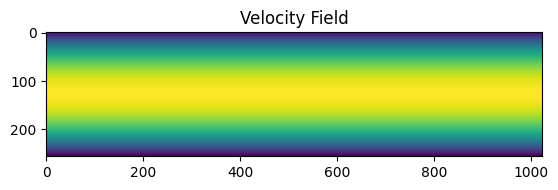

In [6]:
plt.imshow(trajectory_cfd[0].data[-1].T)
plt.title('Velocity Field')

Text(0.5, 1.0, 'Cross Section of Velocity Field')

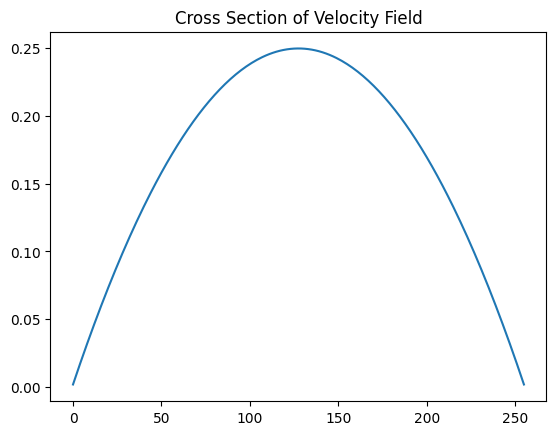

In [7]:
plt.plot(trajectory_cfd[0].data[-1][0])
plt.title('Cross Section of Velocity Field')

## MD Simulation of Taylor Dispersion

### 1. Lagrangian Tracer Particles

Since the velocity field for channel flow is steady in time, we only need to use the velocity field at the last time step to base the simulation of Lagrangian tracer particles.

In [8]:
#interpolate cfd velocity field as a force on particles
def interpolate_pbc(field,list_p, pad_size=2):
    list_p=jnp.moveaxis(list_p,0,-1)
    list_p=list_p.at[0].set(jnp.mod(list_p[0], 4)) #interpolate particle positions modulo box size
    list_p=list_p.at[1].set(jnp.mod(list_p[1], 1)) #interpolate particle positions modulo box size

    grid = field.grid
    offset = field.offset
    dxEUL = grid.step[0]
    dyEUL = grid.step[1]

    xp=list_p[0]+pad_size*dxEUL
    yp=list_p[1]+pad_size*dyEUL
    surface_coord =(((xp)/dxEUL-offset[0]),((yp)/dyEUL-offset[1]))
    return surface_fn_jax_pbc(field.data[-1],surface_coord)

#velocity padding/interpolation function
def surface_fn_jax_pbc(field,surface_coord, pad_size=2):
    field=jnp.pad(field,pad_size,mode='wrap') #pad velocity field
    return jax.scipy.ndimage.map_coordinates(field, surface_coord, order=1) #interpolate

#our custom force function has the force in x and y for each particle in the right format for JAX md
def custom_force_fn_pbc(R, **kwargs):
    u=interpolate_pbc(trajectory_cfd[0],R)
    v=interpolate_pbc(trajectory_cfd[1],R)
    return jnp.moveaxis(jnp.array([u,v]),0,-1)

In [9]:
displacement, shift=space.periodic(np.array([4,1]), wrapped=False)

In [10]:
#initialize particles between height 0.1 and 0.9
R=jnp.column_stack([jnp.zeros(50)+0.1, jnp.linspace(0, 1, 50)])

In [11]:
def energy_fn(R, **kwargs):
    return custom_force_fn_pbc(R)

In [12]:
key = random.PRNGKey(0)
dt=0.001
kT=0
init_fn, apply_fn = simulate.brownian(energy_fn, shift, dt,kT, gamma=1.0)
apply_fn = jit(apply_fn)
state = init_fn(key, R, mass=1.)

def step_fn(state):
    return apply_fn(state)

inner_steps=10
repeated=cfd.funcutils.repeated(step_fn, inner_steps)

post_process= lambda state: state.position

trajectory_fn=cfd.funcutils.trajectory(repeated, 1500, post_process)
final_state, trajectories=trajectory_fn(state)

trajectories=jnp.stack(trajectories)

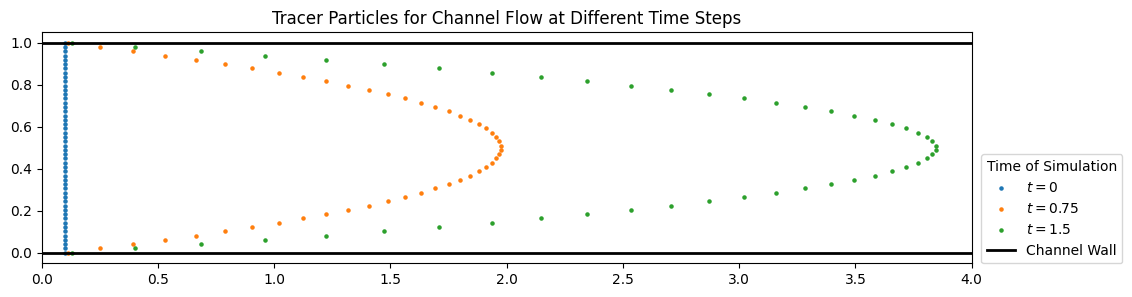

In [13]:
plt.figure(figsize=(12,3))
plt.scatter(R[:,0], R[:,1], s=5, label='$t=0$')
plt.scatter(trajectories[750][:,0], trajectories[750][:,1], s=5, label='$t=0.75$')
plt.scatter(trajectories[-1][:,0], trajectories[-1][:,1], s=5, label='$t=1.5$')
plt.axhline(0,c='black', linewidth=2, label='Channel Wall')
plt.axhline(1, c='black', linewidth=2)
plt.xlim([0,4])
plt.ylim([-0.05,1.05])
plt.title('Tracer Particles for Channel Flow at Different Time Steps')
plt.legend(title='Time of Simulation', loc=(1.01,0))

### 2. Introducing Molecular Diffusion

To include the effects of molecular diffusion, we first need to change the temperature of the MD simulation and make it non-zero.

In [14]:
#initialize particles between height 0.1 and 0.9
R=jnp.column_stack([jnp.zeros(500)+0.1, jnp.linspace(0, 1, 500)])
key = random.PRNGKey(0)
dt=0.001
kT=1e-5
init_fn, apply_fn = simulate.brownian(energy_fn, shift, dt,kT, gamma=1.0)
apply_fn = jit(apply_fn)
state = init_fn(key, R, mass=1.)

def step_fn(state):
    return apply_fn(state)

inner_steps=10
repeated=cfd.funcutils.repeated(step_fn, inner_steps)

post_process= lambda state: state.position

trajectory_fn=cfd.funcutils.trajectory(repeated, 1500, post_process)
final_state, trajectories=trajectory_fn(state)

trajectories=jnp.stack(trajectories)

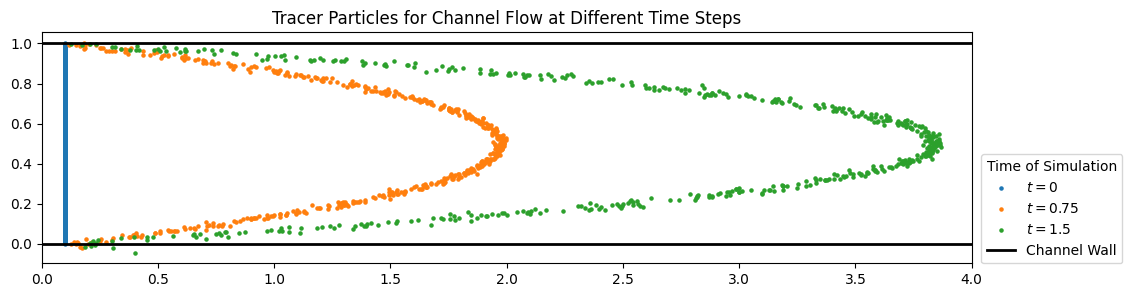

In [15]:
plt.figure(figsize=(12,3))
plt.scatter(R[:,0], R[:,1], s=5, label='$t=0$')
plt.scatter(trajectories[750][:,0], trajectories[750][:,1], s=5, label='$t=0.75$')
plt.scatter(trajectories[-1][:,0], trajectories[-1][:,1], s=5, label='$t=1.5$')
plt.axhline(0,c='black', linewidth=2, label='Channel Wall')
plt.axhline(1, c='black', linewidth=2)
plt.xlim([0,4])
#plt.ylim([-0.05,1.05])
plt.title('Tracer Particles for Channel Flow at Different Time Steps')
plt.legend(title='Time of Simulation', loc=(1.01,0))

Note that although the particles are now advecting according to the velocity field calculated via JAX-CFD and diffusing via Brownian dynamics, when we include Brownian dynamics, even though the velocity is 0 at the wall, the Brownian simulation does not "know" that the walls are impenetrable. We have to enforce this condition on the MD simulation. In the above simulation, a few particles cross the wall. If we increase the temperature even more, we see even more particles diffusing outside of the wall. See the simulation below with a higher temperature.

In [16]:
#initialize particles between height 0.1 and 0.9
R=jnp.column_stack([jnp.zeros(500)+0.1, jnp.linspace(0, 1, 500)])
key = random.PRNGKey(0)
dt=0.001
kT=1e-4
init_fn, apply_fn = simulate.brownian(energy_fn, shift, dt,kT, gamma=1.0)
apply_fn = jit(apply_fn)
state = init_fn(key, R, mass=1.)

def step_fn(state):
    return apply_fn(state)

inner_steps=10
repeated=cfd.funcutils.repeated(step_fn, inner_steps)

post_process= lambda state: state.position

trajectory_fn=cfd.funcutils.trajectory(repeated, 1500, post_process)
final_state, trajectories=trajectory_fn(state)

trajectories=jnp.stack(trajectories)

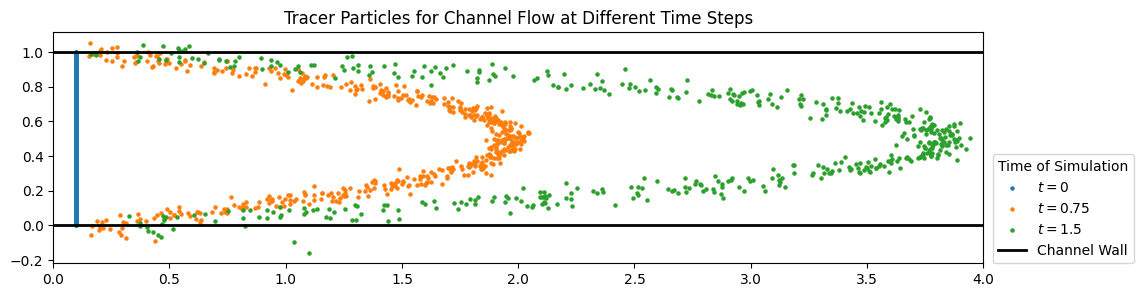

In [17]:
plt.figure(figsize=(12,3))
plt.scatter(R[:,0], R[:,1], s=5, label='$t=0$')
plt.scatter(trajectories[750][:,0], trajectories[750][:,1], s=5, label='$t=0.75$')
plt.scatter(trajectories[-1][:,0], trajectories[-1][:,1], s=5, label='$t=1.5$')
plt.axhline(0,c='black', linewidth=2, label='Channel Wall')
plt.axhline(1, c='black', linewidth=2)
plt.xlim([0,4])
#plt.ylim([-0.05,1.05])
plt.title('Tracer Particles for Channel Flow at Different Time Steps')
plt.legend(title='Time of Simulation', loc=(1.01,0))

### 3. Building Channel Walls

JAX-MD provides the capability to define different species of particles that can interact with each other according to custom potentials. To enforce the impenetrability of the wall, we line the wall with stationary particles that interact with the tracer particles according to the repulsive side of the Morse potential.

When building the channel walls, we face a trade-off when choosing the effective radius and number of particles to line the wall. On the one hand, the fewer the number of wall particles we need to calculate tracer particle interactions with, the faster the simulations will run. On the other hand, we do not want to have very few particles with large effective radii that start to interfere with the simulation by interacting with tracer particles at longer ranges.

Since our simulation has periodic boundary conditions, we only need to place particles on the edge of one of the walls (e.g. the bottom wall) for it to have a symmetric effect on the particles near the other wall.

In [133]:
def gen_wall(num_particles, dom_x, dom_y, rad): #the way we generated the wall here needs work! we just made repulsive particles along the wall
    num_distrib_x=num_particles
    bottom=jnp.moveaxis(jnp.array([jnp.linspace(0+rad, dom_x-rad, num_distrib_x),jnp.zeros(num_distrib_x)]),0,-1)
    all_particles=bottom#jnp.concatenate([bottom, top], axis=0)
    #the selection of radius was somewhat arbitrary, larger time step required more particles with larger radii to prevent particles from diffusing out of the wall
    return jnp.zeros(len(all_particles))+rad, all_particles[:,0], all_particles[:,1]

#### Define Harmonic Morse Potential

In [134]:
def harmonic_morse(dr, h=0.5, D0=0.0, alpha=10.0, r0=1.0, k=50.0, **kwargs):
    U = jnp.where(dr < r0,
               h * k * (dr - r0)**2 - D0,
               D0 * (jnp.exp(-2. * alpha * (dr - r0)) - 2. * jnp.exp(-alpha * (dr - r0)))
               )
    return jnp.array(U, dtype=dr.dtype)

<ipython-input-134-56bfccffeada>:6: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jnp.array(U, dtype=dr.dtype)


Text(0.5, 1.0, 'Morse Potential')

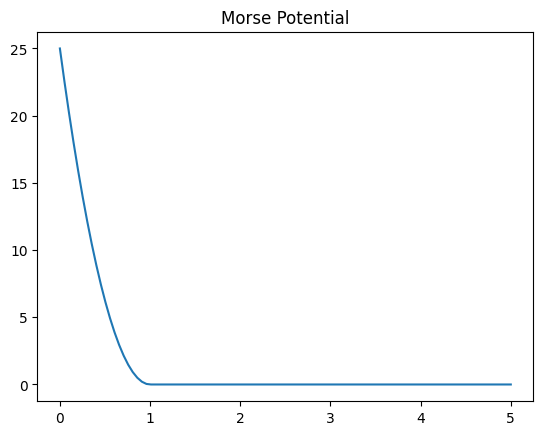

In [135]:
dr=np.linspace(0,5,100)
plt.plot(dr,harmonic_morse(dr))
plt.title('Morse Potential')

Following the JAX-MD Custom Potential Demo (linked here: https://github.com/jax-md/jax-md/blob/main/notebooks/customizing_potentials_cookbook.ipynb), we use smap.pair to calculate the potential between all particle pairs. The custom potentials demo says, "The JAX MD function smap.pair takes a given potential and promotes it to act on all particle pairs in a system. smap.pair does not actually return an energy, rather it returns a function that can be used to calculate the energy."

In [136]:
def harmonic_morse_pair(displacement_or_metric, species=None, h=0.5, D0=5.0, alpha=10.0, r0=1.0, k=50.0):
    h = jnp.array(h, dtype=f32)
    D0 = jnp.array(D0, dtype=f32)
    alpha = jnp.array(alpha, dtype=f32)
    r0 = jnp.array(r0, dtype=f32)
    k = jnp.array(k, dtype=f32)
    return smap.pair(harmonic_morse,space.canonicalize_displacement_or_metric(displacement_or_metric),
                     species=species,h=h,D0=D0,alpha=alpha,r0=r0,k=k)
fixed_harmonic = lambda displacement_or_metric, h,r0: harmonic_morse_pair(displacement_or_metric, species=species, h=h, D0=0.0, alpha=10.0, r0=r0, k=1.0)

Now, we have to define the parameters of the Morse potential governing the interaction between each class of particles. In this function, we initialize the positions of the tracer particles, the wall particles, and strength of the interactions between them. We assume that the tracer particles do not interact with other tracer particles, and the wall particles do not interact with other wall particles. Only the tracer particles and the wall particles interact.

In [137]:
def particle_initialize(num_distrib, y_start, y_stop):
    #initialize location of particles
    R=jnp.moveaxis(jnp.array([jnp.zeros(num_distrib)+0.1,jnp.linspace(y_start, y_stop, num_distrib)]),0,-1)

    is_mobile=np.zeros(len(R))+1 #initialize is_mobile to be one for all particles (0 immobile, 1 mobile)

    #gen_wall(number_of_wall_particles, x_domain_size, y_domain_size, radius_of_wall_particle), returns radius, x_list, y_list of wall particles
    rad,x_pos, y_pos=gen_wall(500, 4.,1.,0.01)

    #add on immobile wall particles
    pos_fixed=jnp.moveaxis(jnp.array([x_pos, y_pos]),0,-1)
    R=jnp.concatenate([R, pos_fixed])
    is_mobile=jnp.concatenate([is_mobile, jnp.zeros([len(pos_fixed)])])

    #specify two species
    num_spec=2#len(rad)+1

    #specify morse potential parameters for the immobile species
    r0_array=jnp.zeros([num_spec,num_spec]).at[0,jnp.arange(1,num_spec)].set(rad[0])
    r0_array=r0_array.at[np.arange(1,num_spec),0].set(rad[0])

    h_array=jnp.zeros([num_spec,num_spec]).at[0,jnp.arange(1,num_spec)].set(10.0)
    h_array=h_array.at[np.arange(1,num_spec),0].set(10.0)
    return R, is_mobile, r0_array, h_array

#### Make Wall Particles Immobile

Now, we have to modify the shift function so that the wall particles remain fixed during the molecular dynamics simulation.

In [138]:
  def masked_shift(R, dR, is_mobile=None):
      if is_mobile is None:
          return shift(R, dR)
      return jnp.where(is_mobile[:, None], shift(R, dR), R)

#### Full Simulation with Wall

Now that we have added the wall particles by introducing interactions between two species of particles, the molecular dynamics simulation becomes a bit more complicated. We now have to define an energy function that adds the effect of the force field from the CFD simulation and the potential created by each wall particle at every step.

In [139]:
#specify displacement and shift function, including md box size (4,1) here and unwrapped particle positions
displacement, shift=space.periodic(np.array([4,1]), wrapped=False)#, wrapped=False)

#select the number of tracer particles
num_particles=500

species=jnp.full(num_particles, 0)
species=jnp.concatenate([species, jnp.array([1]*500)])

#initialize particles between height 0.1 and 0.9
R, is_mobile, r0_array, h_array=particle_initialize(num_particles, 0.,1.0)

#specify our energy function as the morse potential with parameters corresponding to each species type as inputs
energy_fn = fixed_harmonic(displacement, h_array, r0_array)

#convert force to energy to combine with force from cfd velocity field
energy_fn=quantity.force(energy_fn)

#Define new energy function that is the sum of our cfd force fn and repulsive particles
def new_energy_fn(R, **kwargs):
    return custom_force_fn_pbc(R)+energy_fn(R)

dt = 0.001
temperature = 1e-4

key = random.PRNGKey(0)
init_fn, apply_fn = simulate.brownian(new_energy_fn, masked_shift, dt,temperature, gamma=1.0)
apply_fn = jit(apply_fn)
state = init_fn(key, R, mass=1.)

def step_fn(state):
    return apply_fn(state, is_mobile=is_mobile)

inner_steps=10
repeated=cfd.funcutils.repeated(step_fn, inner_steps)

post_process= lambda state: state.position

trajectory_fn=cfd.funcutils.trajectory(repeated, 1500, post_process)
final_state, trajectories=trajectory_fn(state)

trajectories=jnp.stack(trajectories)

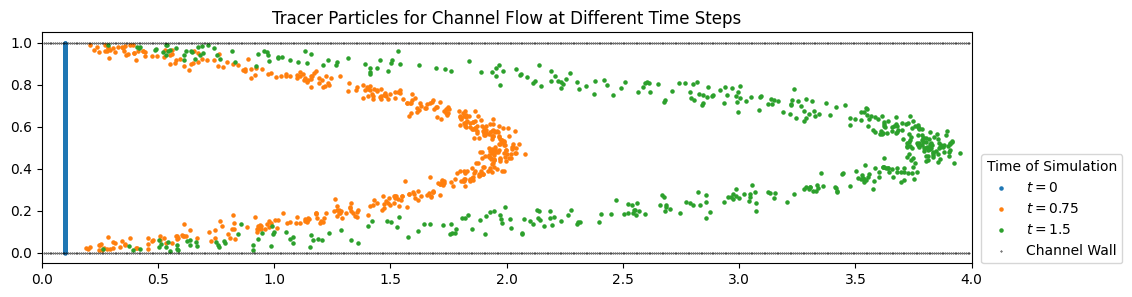

In [140]:
plt.figure(figsize=(12,3))
plt.scatter(R[:,0][:-500], R[:,1][:-500], s=5, label='$t=0$')
plt.scatter(trajectories[750][:,0][:-500], trajectories[750][:,1][:-500], s=5, label='$t=0.75$')
plt.scatter(trajectories[-1][:,0][:-500], trajectories[-1][:,1][:-500], s=5, label='$t=1.5$')
plt.scatter(R[:,0][-500:],R[:,1][-500:], s=0.5, marker='.', label='Channel Wall', c='black')
plt.scatter(R[:,0][-500:],R[:,1][-500:]+1, s=0.5, marker='.', c='black')
plt.xlim([0,4])
#plt.ylim([-0.05,1.05])
plt.title('Tracer Particles for Channel Flow at Different Time Steps')
plt.legend(title='Time of Simulation', loc=(1.01,0))

The plot aboves shows that we are able to simulate diffusing tracer particles in a channel with the impenetrability conditions at the wall reinforced.

** **Note:** The number of wall particles and the radius of the wall particles may need to be changed based on the molecular diffusivity of the tracer particles and the time step being used in the simulation in order to reinforce the wall. With high diffusivities and large time steps, more wall particles with larger radii may be required to reinforce the wall. The wall parameters can be tuned by setting the parameters of gen_wall() in the particle_initialize() function. In the above simulation, we use 500 wall particles each with a radius of 0.01.